# An Introduction to Time Series Analyis

## Import libraries

In [108]:
import sys
sys.path.append('/home/eric/credentials')
import credentials
import requests
from xml.etree import ElementTree
from datetime import datetime
import dateparser
from astral import Astral
import folium
from pyproj import Proj, transform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
import matplotlib.dates as mdates
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%load_ext rpy2.ipython
#import statsmodels as sm

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
def parse_coords(coord):
    coord = coord.replace(u'\xa0', u'')
    coord = coord.replace(',', '.')
    return(float(coord))

def add_zero(j):
    if len(str(j)) == 1:
        return '0' + str(j)
    else:
        return str(j)

In this tutorial we will be using time series methods to analyse and forecast the number of weekly cyclists in the Helsinki region. The data is collected by a number of automated counters located around the center of Helsinki. Data has been collected since 2014 and is available through the [Helsinki open data service](https://hri.fi/).

## Cycling data

Let's start by reading the data from the data portal using the [pandas](https://pandas.pydata.org/) package.

In [3]:
url = 'http://www.hel.fi/hel2/tietokeskus/data/helsinki/ksv/Helsingin_pyorailijamaarat.csv'
cycle_data = pd.read_csv(url, encoding = 'latin', sep = ';')
cycle_data.drop('Unnamed: 21', axis = 1, inplace = True)
cycle_data.dropna(how = 'all', inplace = True)

In [4]:
cycle_data['Date'] = cycle_data['Päivämäärä'].apply(dateparser.parse)
cycle_data.index = cycle_data['Date']
cycle_data.drop(['Päivämäärä', 'Date'], axis = 1, inplace = True)
cycle_data['Total'] = cycle_data.sum(axis = 1, skipna = True)
cycle_data['Counters'] = cycle_data.iloc[:, 0:cycle_data.shape[1] - 1].count(axis = 1)

In [5]:
url = 'http://www.hel.fi/hel2/tietokeskus/data/helsinki/ksv/pyoralaskentapisteiden_sijainnit.csv'
location_data = pd.read_csv(url, encoding = 'latin', sep = ';')
location_data.columns = ['Name', 'x', 'y']
location_data['x'] = location_data['x'].apply(parse_coords)
location_data['y'] = location_data['y'].apply(parse_coords)

In [6]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
hours = [add_zero(i) for i in range(0, 24, 2)]
#hours = [(pd.to_datetime(t, format='%H')).time() for t in range(24)]
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
#date_range = pd.date_range(datetime.strptime('2014-01-01', '%Y-%m-%d'), 
#  datetime.strptime('2018-08-01', '%Y-%m-%d'), freq = '6M')

cycle_data_daily = pd.DataFrame(cycle_data['Total'].resample('D', label = 'left').sum())
cycle_data_daily['Counters'] = cycle_data['Counters'].resample('D', label = 'left').median()
cycle_data_daily['Counters'] = cycle_data_daily['Counters'].round(0)
cycle_data_weekly = pd.DataFrame(cycle_data['Total'].resample('W', label = 'right').sum())
cycle_data_weekly['Counters'] = cycle_data_daily['Counters'].resample('W', label = 'right').median()
cycle_data_monthly = pd.DataFrame(cycle_data['Total'].resample('M', label = 'right').sum())
cycle_data_monthly['Counters'] = cycle_data_daily['Counters'].resample('M', label = 'right').median()
cycle_data_bday = cycle_data[cycle_data.index.weekday < 5]
cycle_data_wkend = cycle_data[cycle_data.index.weekday > 4]

cycle_data_day = cycle_data_daily.groupby(by = cycle_data_daily.index.dayofweek).mean()
cycle_data_month = cycle_data_daily.groupby(cycle_data_daily.index.month).mean()
cycle_data_bday_hour = cycle_data_bday.groupby(cycle_data_bday.index.hour).median()
cycle_data_wkend_hour = cycle_data_wkend.groupby(cycle_data_wkend.index.hour).median()

In [7]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
hours = [add_zero(i) for i in range(0, 24, 2)]
#hours = [(pd.to_datetime(t, format='%H')).time() for t in range(24)]
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
#date_range = pd.date_range(datetime.strptime('2014-01-01', '%Y-%m-%d'), 
#  datetime.strptime('2018-08-01', '%Y-%m-%d'), freq = '6M')

cycle_data_daily = pd.DataFrame(cycle_data['Total'].resample('D', label = 'left').sum())
cycle_data_daily['Counters'] = cycle_data['Counters'].resample('D', label = 'left').median()
cycle_data_daily['Counters'] = cycle_data_daily['Counters'].round(0)
cycle_data_weekly = pd.DataFrame(cycle_data['Total'].resample('W', label = 'right').sum())
cycle_data_weekly['Counters'] = cycle_data_daily['Counters'].resample('W', label = 'right').median()
cycle_data_monthly = pd.DataFrame(cycle_data['Total'].resample('M', label = 'right').sum())
cycle_data_monthly['Counters'] = cycle_data_daily['Counters'].resample('M', label = 'right').median()
cycle_data_bday = cycle_data[cycle_data.index.weekday < 5]
cycle_data_wkend = cycle_data[cycle_data.index.weekday > 4]

cycle_data_day = cycle_data_daily.groupby(by = cycle_data_daily.index.dayofweek).median()
cycle_data_month = cycle_data_monthly.groupby(cycle_data_monthly.index.month).median()
cycle_data_bday_hour = cycle_data_bday.groupby(cycle_data_bday.index.hour).median()
cycle_data_wkend_hour = cycle_data_wkend.groupby(cycle_data_wkend.index.hour).median()

bday_dict = {}
for date in cycle_data_bday['Total'].groupby(cycle_data_bday.index.date):
    bday_dict[date[0]] = date[1].values
bday_df = pd.DataFrame.from_dict(bday_dict)

wkend_dict = {}
for date in cycle_data_wkend['Total'].groupby(cycle_data_wkend.index.date):
    wkend_dict[date[0]] = date[1].values
wkend_df = pd.DataFrame.from_dict(wkend_dict)

# Explore cycling data

Now that we have the data loaded, let's have a look at it. We can start by visualising the locations of automated counters on a map using the [folium](https://github.com/python-visualization/folium) package, which enables the creation of leaflet.js maps in python.

In [8]:
# convert coordinates from ETRS89/GK25FIN to WGS 84
input_epsg = Proj(init='epsg:3879')
output_epsg = Proj(init='epsg:4326')

x_array = np.array(location_data['x'])
y_array = np.array(location_data['y'])

lons, lats = transform(input_epsg, output_epsg, x_array, y_array)

In [9]:
# plot cycle count locations on map
cycle_map = folium.Map(location=[np.mean(lats), np.mean(lons)], zoom_start = 12)
feature_group = folium.FeatureGroup('Locations')
for lat, lon, name in zip(lats, lons, location_data['Name']):
    feature_group.add_child(folium.Marker(location = [lat,lon], popup = name))
cycle_map.add_child(feature_group)

Then we can visualaise the time series of the weekly number of cyclists and the number of automated counters.

In [10]:
cycle_data.describe()

,Auroransilta,Eteläesplanadi,Huopalahti (asema),Kaisaniemi/Eläintarhanlahti,Kaivokatu,Kulosaaren silta et.,Kulosaaren silta po.,Kuusisaarentie,"Käpylä, Pohjoisbaana",Lauttasaaren silta eteläpuoli,...,Munkkiniemi silta pohjoispuoli,Heperian puisto/Ooppera,Pitkäsilta itäpuoli,Pitkäsilta länsipuoli,Lauttasaaren silta pohjoispuoli,Ratapihantie,Viikintie,Baana,Total,Counters
count,3314.000000,37104.000000,25343.000000,37126.000000,3312.000000,25343.000000,25343.000000,25343.000000,4749.000000,30238.000000,...,37126.000000,35950.000000,30238.000000,37126.000000,30238.000000,25343.000000,3320.000000,37128.000000,37128.000000,37128.000000
mean,16.605009,50.923836,46.854279,46.974223,28.189010,0.041076,69.049915,41.792132,21.359444,79.036477,...,33.479098,85.390320,65.966962,37.955422,34.350486,55.298583,6.138253,88.859755,727.313752,14.033829
std,25.018254,65.358054,72.743539,64.184000,31.480894,0.272387,97.478033,62.253183,33.010636,105.349398,...,51.973562,122.082921,86.343471,42.624169,48.619974,84.871346,7.858372,118.811952,1012.734521,3.995788
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,1.000000,5.000000,4.000000,4.000000,4.000000,0.000000,7.000000,3.000000,2.000000,8.000000,...,2.000000,7.000000,8.000000,7.000000,4.000000,7.000000,0.000000,9.000000,76.000000,11.000000
50%,8.000000,23.000000,18.000000,20.000000,17.000000,0.000000,28.000000,14.000000,9.000000,35.000000,...,12.000000,32.000000,30.000000,21.000000,15.000000,23.000000,3.000000,38.000000,313.000000,16.000000
75%,20.000000,74.000000,57.000000,66.000000,42.000000,0.000000,93.000000,56.000000,26.000000,110.000000,...,44.000000,116.000000,92.000000,56.000000,46.000000,66.000000,9.000000,126.000000,972.000000,16.000000
max,215.000000,1172.000000,688.000000,513.000000,230.000000,10.000000,894.000000,466.000000,279.000000,950.000000,...,537.000000,1153.000000,636.000000,340.000000,511.000000,836.000000,61.000000,822.000000,8294.000000,20.000000


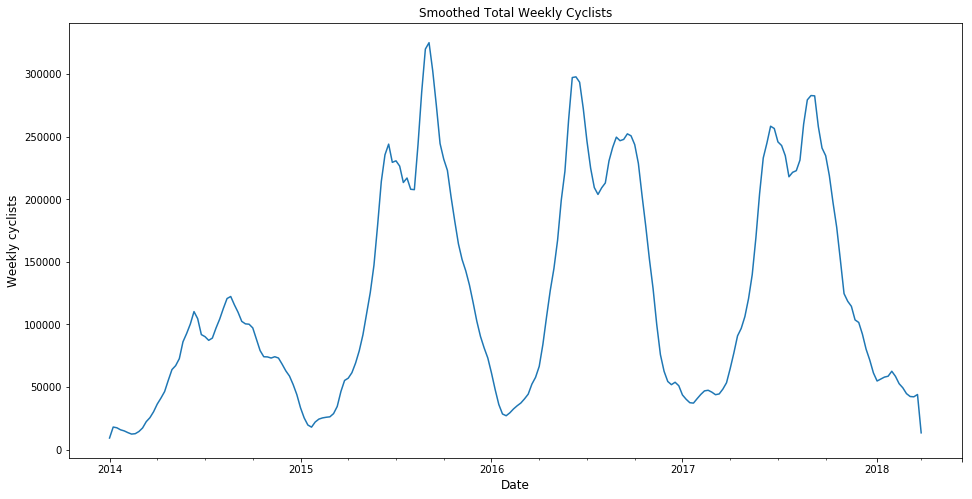

In [109]:
# plot time series of weekly cyclists
cycle_data_weekly_roll = cycle_data['Total'].rolling('30D', min_periods = 15).mean().resample('W').sum()
cycle_data_weekly_roll.plot()
plt.gca().xaxis.set_label_text('Date', fontsize = 12)
plt.gca().yaxis.set_label_text('Weekly cyclists', fontsize = 12)
plt.title('Smoothed Total Weekly Cyclists')
plt.show()

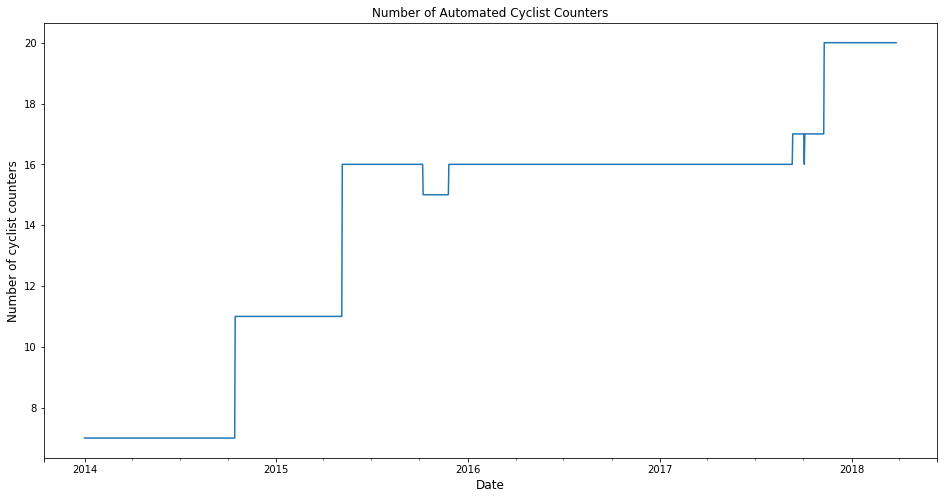

In [110]:
# plot time series of bicycle counters
cycle_data_daily['Counters'].plot()
plt.gca().xaxis.set_label_text('Date', fontsize = 12)
plt.gca().yaxis.set_label_text('Number of cyclist counters', fontsize = 12)
plt.title('Number of Automated Cyclist Counters')
plt.show()

There is a clear yearly cycle in the data but the first year (2014) shows much less cyclists than subsequent years. This is most likely caused by the small number of automated counters during the first year.

Let's continue by plotting the data averaged by month.

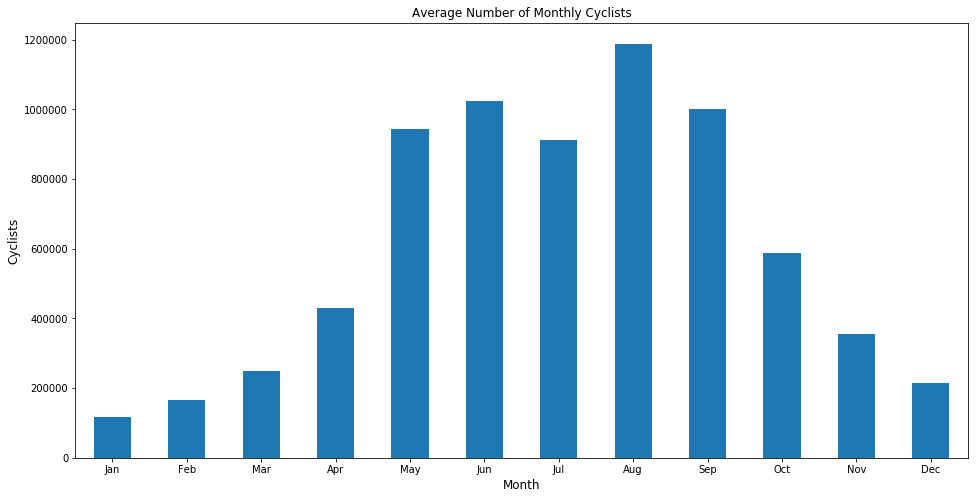

In [111]:
cycle_data_month['Total'].plot(kind = 'bar', color='#1f77b4')
plt.gca().xaxis.set_ticklabels(months, rotation = 0)
plt.gca().xaxis.set_label_text('Month', fontsize = 12)
plt.gca().yaxis.set_label_text('Cyclists', fontsize = 12)
plt.title('Average Number of Monthly Cyclists')
plt.show()

The highest numbers of cyclists are recorded between May and September, but there is a dip in July, most likely caused by people on holiday.

Drilling a bit deeper, let's visualise the average numbers of cyclists during each day of the week.

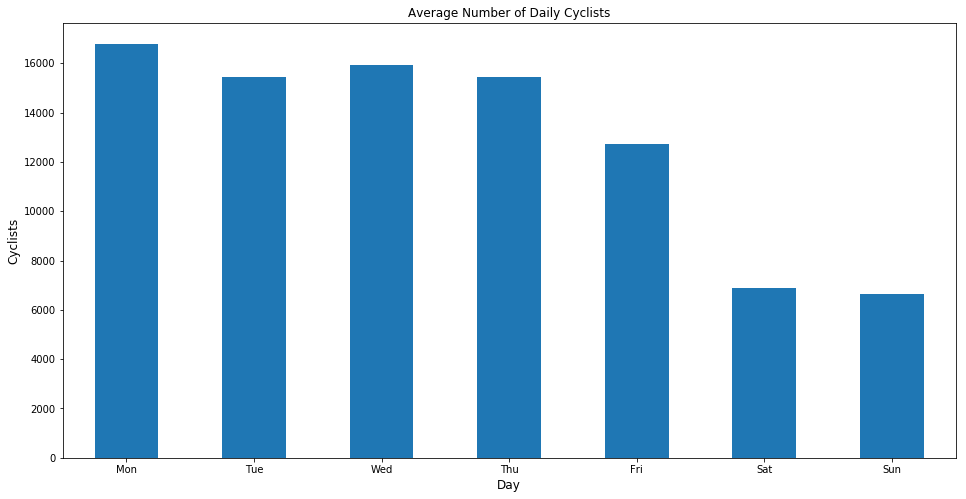

In [112]:
cycle_data_day['Total'].plot(kind = 'bar', color='#1f77b4')
plt.gca().xaxis.set_ticklabels(days, rotation = 0)
plt.gca().xaxis.set_label_text('Day', fontsize = 12)
plt.gca().yaxis.set_label_text('Cyclists', fontsize = 12)
plt.title('Average Number of Daily Cyclists')
plt.show()

The beginning of the week shows the highest numbers of cyclists, with a decreasing trend towards the weekend. Weekends clearly have less cyclists, reflecting the popularity of cycling to work.

Looking deeper still, we can plot how the number of cyclists differs within days. Working days (blue) and weekends (red) have been plotted with different colours. Medians are plotted with single thick lines.

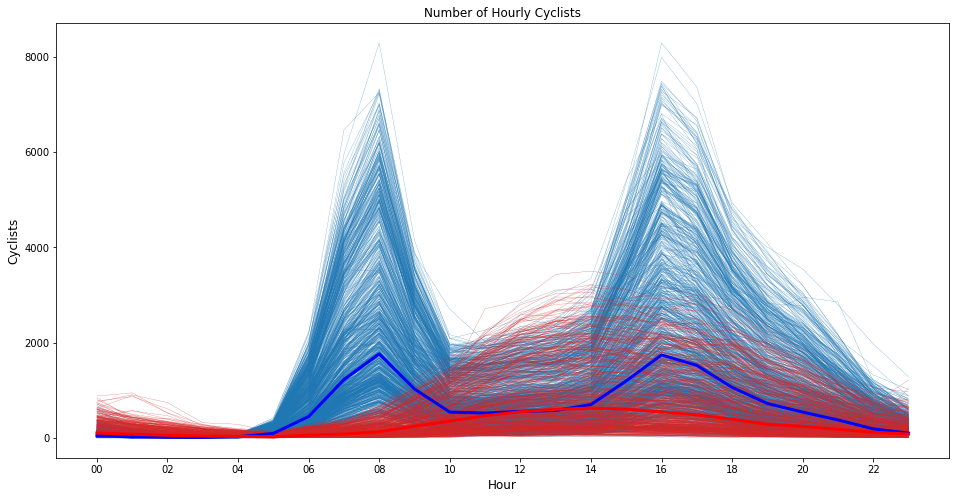

In [113]:
plt.plot(bday_df, color = '#1f77b4', linewidth = 0.2)
plt.plot(wkend_df, color = '#d62728', linewidth = 0.2)
plt.plot(cycle_data_bday_hour['Total'], color = 'blue', linewidth = 3)
plt.plot(cycle_data_wkend_hour['Total'], color = 'red', linewidth = 3)
plt.gca().xaxis.set_ticks(range(0, 24, 2))
plt.gca().xaxis.set_ticklabels(hours)
plt.gca().xaxis.set_label_text('Hour', fontsize = 12)
plt.gca().yaxis.set_label_text('Cyclists', fontsize = 12)
plt.title('Number of Hourly Cyclists')
plt.show()

We can see that during week days there are two spikes, reflected people cycling to and from work, while during the weekends the number of cyclists steadily increases until the early afternoon, after which it decreases.

## Weather data

One of the most obvious factors impacting the number of cyclists will be the weather. We download weather data from the same period as cycling data has been collected from the open data portal of the [Finnish Meteorological Institute](https://en.ilmatieteenlaitos.fi/open-data).

In [16]:
def get_fmi_data (fmi_id, start_date, end_date):
    url = 'http://data.fmi.fi/fmi-apikey/'+credentials.login['fmi_api_key']+'/wfs?request=getFeature&storedquery_id=fmi::observations::weather::daily::multipointcoverage&fmisid='+fmi_id+'&starttime='+start_date+'&endtime='+end_date
    return requests.get(url)

In [17]:
# define weather station
fmi_id = '101004'

In [18]:
# fmi weather data can only be loaded in 1-year chunks. Here we loop through each
# year, load, parse and join the weather data
date_list = []
weather_list = []
for year in cycle_data.index.year.unique():
    start_date = str(year) + '-01-01'
    end_date = str(year) + '-12-31'
    print(start_date, ' - ', end_date)
    request = get_fmi_data(fmi_id, start_date, end_date)
    root = ElementTree.fromstring(request.content)
    for position in root.iter('{http://www.opengis.net/gmlcov/1.0}positions'):
        for row in position.text.split('\n')[1:-1]:
            date_list.append(datetime.fromtimestamp(int(row.split()[2])).strftime('%Y-%m-%d %H:%M'))
    for observation in root.iter('{http://www.opengis.net/gml/3.2}doubleOrNilReasonTupleList'):
        for row in observation.text.split('\n')[1:-1]:
            weather_list.append([float(i) for i in row.split()])   

2014-01-01  -  2014-12-31
2015-01-01  -  2015-12-31
2016-01-01  -  2016-12-31
2017-01-01  -  2017-12-31
2018-01-01  -  2018-12-31


In [19]:
weather_df = pd.DataFrame(weather_list)
date_df = pd.DataFrame(date_list, dtype = 'datetime64')
weather_data = pd.concat([date_df, weather_df], axis = 1)
weather_names = ['Date', 'Rain_total', 'Temp_mean', 'Snow_depth', 'Temp_min', 'Temp_max', 'Grass_temp_min']
weather_data.columns = weather_names
weather_data.index = weather_data.Date
weather_data.drop(['Date', 'Grass_temp_min'], axis = 1, inplace = True)
weather_data.dropna(thresh = 2, inplace = True)
weather_data.loc[:, ['Rain_total', 'Snow_depth']] = weather_data.loc[:, ['Rain_total', 'Snow_depth']].replace(-1.0, np.nan)

weather_data_weekly = weather_data.resample('W').median()
weather_data_weekly['Temp_min'] = weather_data['Temp_min'].resample('W').min()
weather_data_weekly['Temp_max'] = weather_data['Temp_max'].resample('W').max()
weather_data_weekly['Rain_total'] = weather_data['Rain_total'].resample('1W').sum()

 Let's print summary statistics and visualise the weather data.

In [20]:
weather_data.describe()

,Rain_total,Temp_mean,Snow_depth,Temp_min,Temp_max
count,873.000000,1673.000000,417.000000,1671.000000,1671.00000
mean,3.535624,6.926958,10.390887,3.812986,10.25009
std,5.122213,8.358116,7.347044,7.908397,9.19065
min,0.000000,-23.400000,0.000000,-25.300000,-21.40000
25%,0.400000,1.200000,5.000000,-0.700000,3.00000
50%,1.500000,6.000000,8.000000,3.000000,9.30000
75%,4.700000,14.000000,16.000000,10.100000,18.00000
max,46.100000,26.700000,32.000000,22.800000,31.60000


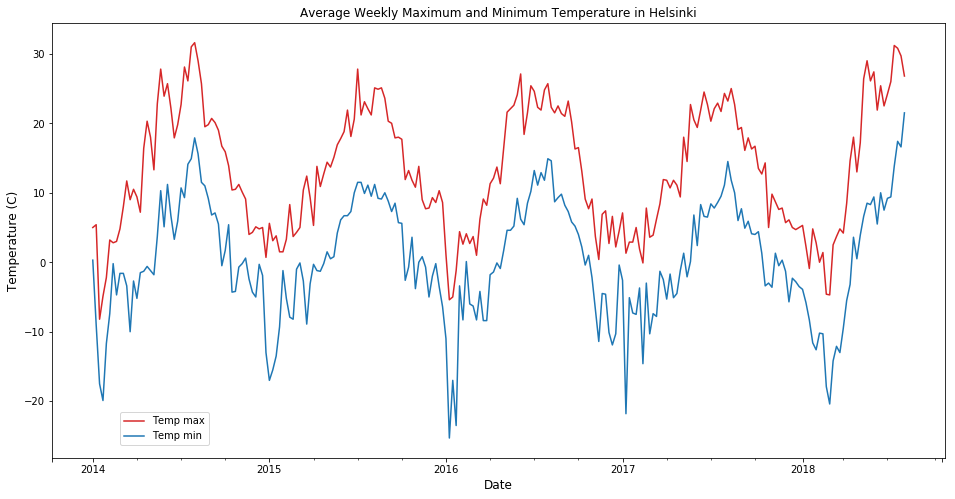

In [114]:
weather_data_weekly.loc[:, ['Temp_max', 'Temp_min']].plot(legend = False, color = ['#d62728', '#1f77b4'])
plt.gcf().legend(['Temp max', 'Temp min'], loc='lower left', bbox_to_anchor=(0.1, 0.085))
plt.gca().xaxis.set_label_text('Date', fontsize = 12)
plt.gca().yaxis.set_label_text('Temperature (C)', fontsize = 12)
plt.title('Average Weekly Maximum and Minimum Temperature in Helsinki')
plt.show()

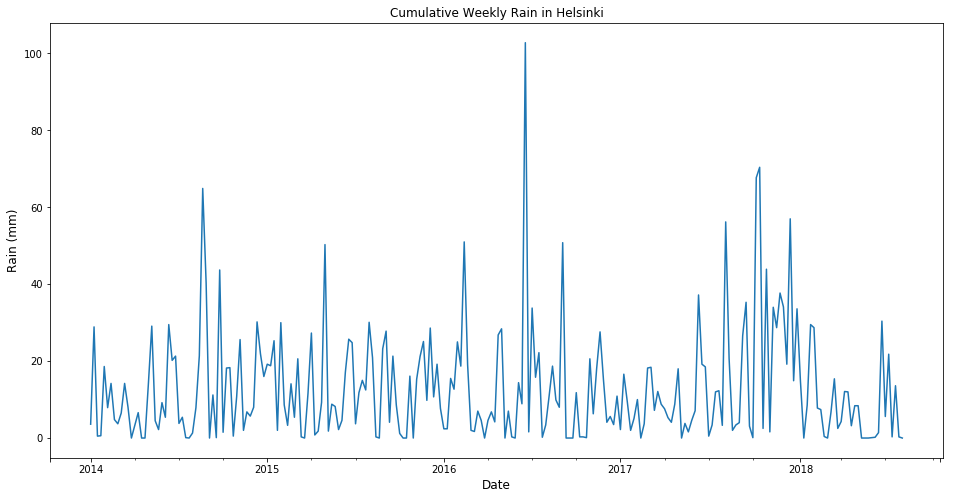

In [115]:
weather_data_weekly['Rain_total'].plot()
plt.gca().xaxis.set_label_text('Date', fontsize = 12)
plt.gca().yaxis.set_label_text('Rain (mm)', fontsize = 12)
plt.title('Cumulative Weekly Rain in Helsinki')
plt.show()

# Calculate day length

In addition to weather, we might expect daylength to also influence the number of cyclists. Let's calculate daylength in Helsinki for each time point in our data using the [astral](https://astral.readthedocs.io/en/latest/) package.

In [23]:
city = Astral()['Helsinki']
def calc_daylength(date):
    return (city.sunset(date) - city.sunrise(date)).seconds / 3600

weather_data_weekly['Daylight'] = list(map(calc_daylength, weather_data_weekly.index))

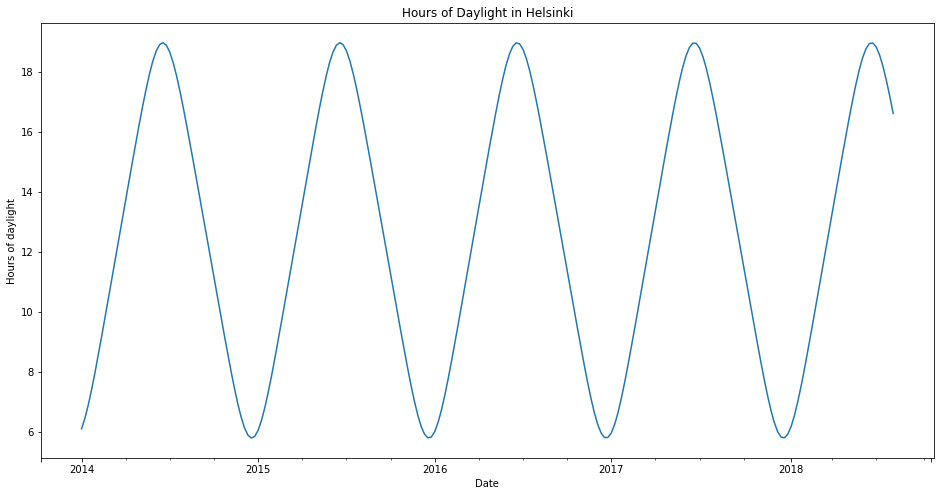

In [116]:
# Plot the daylight curve
weather_data_weekly['Daylight'].plot()
plt.ylabel('Hours of daylight')
plt.title('Hours of Daylight in Helsinki')
plt.show()

## Do time series analysis with R

Now that we have all our data we can start to do some simple time series analyses. We will now transfer over to R and use the [forecast](https://cran.r-project.org/web/packages/forecast/forecast.pdf) library to study our time series and introduce some forecasting methods.

In [25]:
combined_data = pd.DataFrame.join(cycle_data_weekly, weather_data_weekly, how = 'right')
combined_data['Counters'].fillna(method='ffill', inplace = True)

In [96]:
%%R -i combined_data
library(forecast)
library(ggplot2)
library(base)
library(scales)
library(repr)
options(repr.plot.width = 15, repr.plot.height = 15)

In [27]:
%%R
cycle_ts <- stats::ts(combined_data, freq = 52, start = 2014)
train_data <- stats::window(cycle_ts, end = c(2017, 26))
pred_data <- stats::window(cycle_ts, start = c(2017, 27))

Let's start by decomposing the cycling time series into its seasonal, trend and residual components.

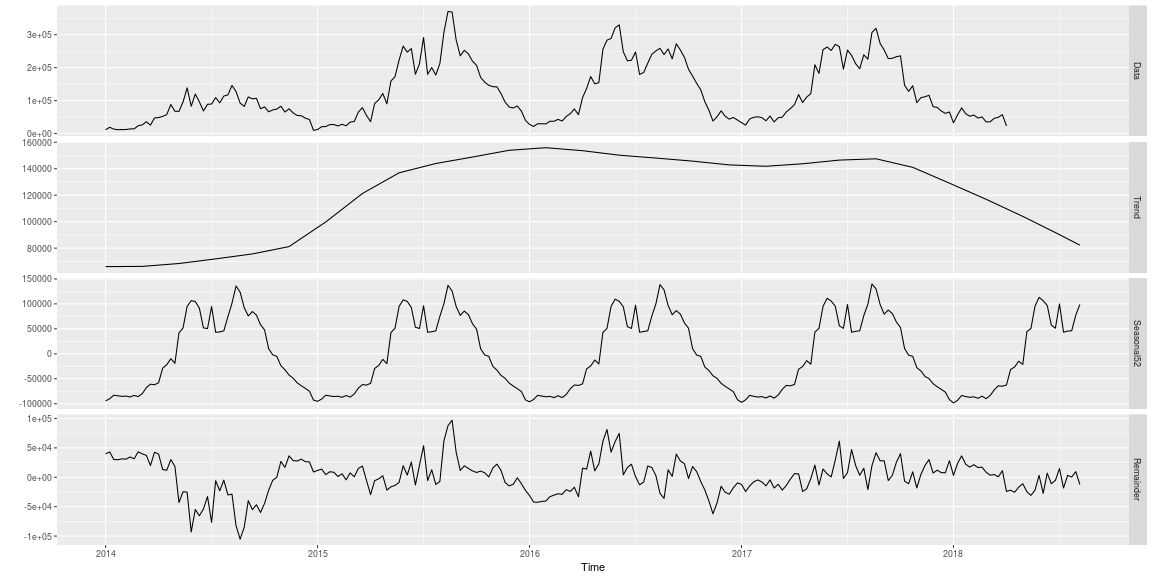

In [117]:
%%R -w 16 -h 8 -u in
stats::window(cycle_ts[, 'Total']) %>% mstl() %>% ggplot2::autoplot()

The trend panel is rather interesting. It clearly shows the initial increase in cyclist numbers caused by the increased number of automated counters. However, after the initial rise, there appears to be a slow decline in cyclists. The sharp decrease at the end is an artifact of the data ending at a low point.

Let's continue by introducing some forecasting methods. There are a number of different methods we can use, ranging from very simple to very complicated. Here are a few of the more simple ones.

1. Average: Future values are predicted to be the mean of all previous observations.
2. Naïve: Future values are predicted to be the same as the last observation.
3. Seasonal naïve: Each future value is predicted to be the same as the value from the same time point in the previous cycle.
4. Drift: Future values are predicted to follow a straight line that follows the average change through time.

In [30]:
%%R
# specify time horizon for forecast in weeks
h <- 58

In [ ]:
%%R
cycle_mean <- forecast::meanf(train_data[, 'Total'], h)

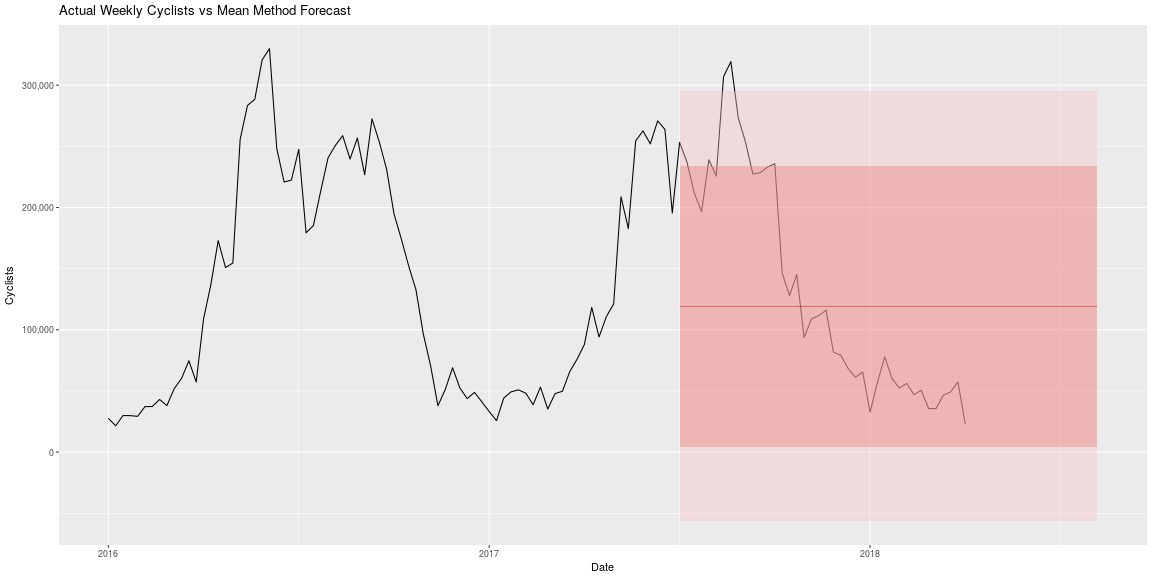

In [118]:
%%R -w 16 -h 8 -u in
ggplot2::autoplot(stats::window(cycle_ts[, 'Total'], start = 2016)) + 
  autolayer(cycle_mean, PI = TRUE, , col = 'red', alpha = 0.4) + 
  xlab('Date') + ylab('Cyclists') + 
  scale_y_continuous(labels = scales::comma) + 
  ggtitle('Actual Weekly Cyclists vs Mean Method Forecast')

In [ ]:
%%R
cycle_naive <- forecast::naive(train_data[, 'Total'], h)

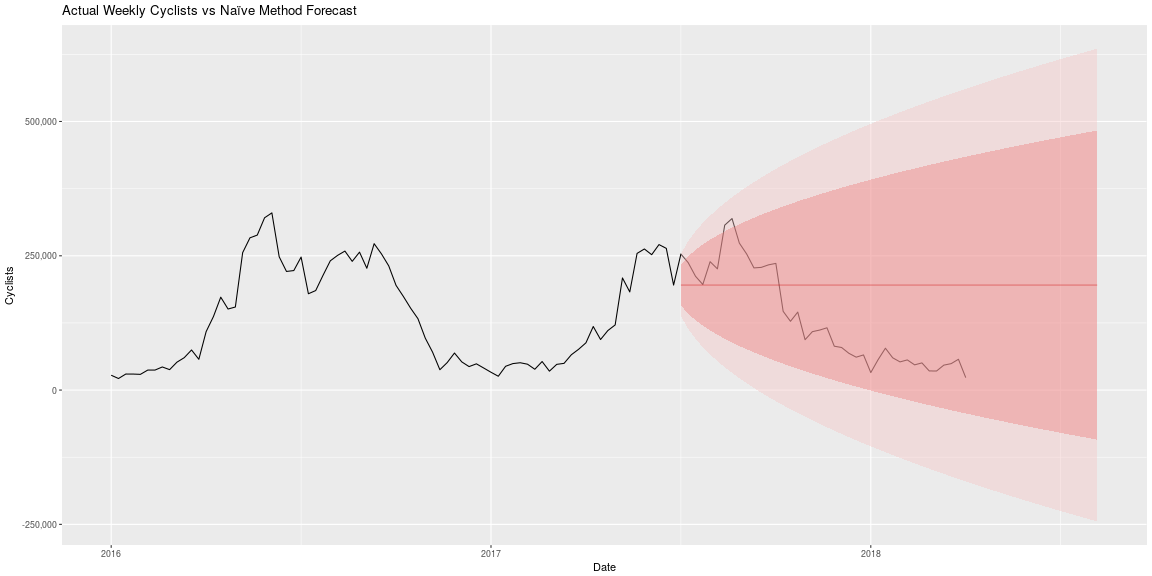

In [119]:
%%R -w 16 -h 8 -u in
ggplot2::autoplot(stats::window(cycle_ts[, 'Total'], start = 2016)) + 
  autolayer(cycle_naive, PI = TRUE, col = 'red', alpha = 0.4) + 
  xlab('Date') + ylab('Cyclists') + 
  scale_y_continuous(labels = scales::comma) + 
  ggtitle('Actual Weekly Cyclists vs Naïve Method Forecast')

In [ ]:
%%R
cycle_snaive <- forecast::snaive(train_data[, 'Total'], h)

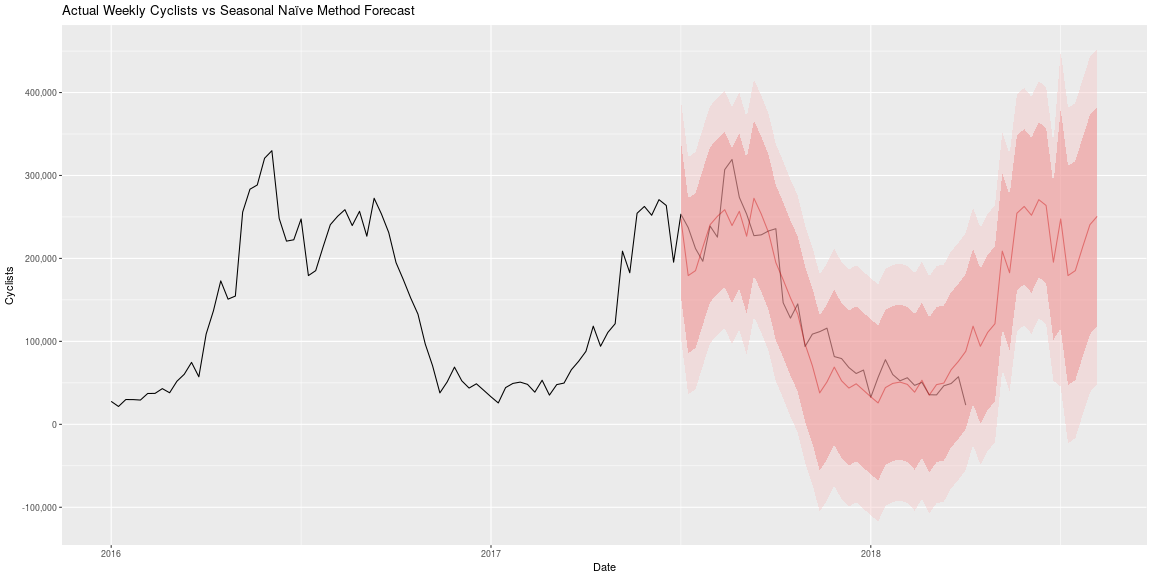

In [120]:
%%R -w 16 -h 8 -u in
ggplot2::autoplot(stats::window(cycle_ts[, 'Total'], start = 2016)) + 
  autolayer(cycle_snaive, PI = TRUE, col = 'red', alpha = 0.4) + 
  xlab('Date') + ylab('Cyclists') + 
  scale_y_continuous(labels = scales::comma) + 
  ggtitle('Actual Weekly Cyclists vs Seasonal Naïve Method Forecast')

In [ ]:
%%R
cycle_drift <- forecast::rwf(train_data[, 'Total'], drift = TRUE, h)

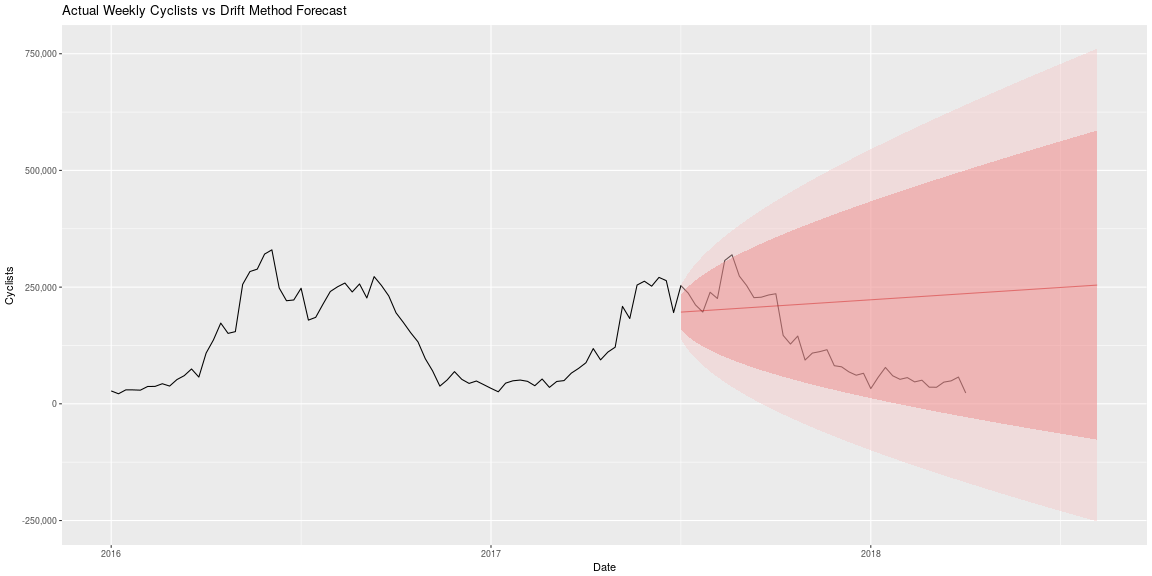

In [121]:
%%R -w 16 -h 8 -u in
ggplot2::autoplot(stats::window(cycle_ts[, 'Total'], start = 2016)) + 
  autolayer(cycle_drift, PI = TRUE, col = 'red', alpha = 0.4) + 
  xlab('Date') + ylab('Cyclists') + 
  scale_y_continuous(labels = scales::comma) + 
  ggtitle('Actual Weekly Cyclists vs Drift Method Forecast')

In addition to the four simple methods outlined above, there are more advanced methods for forecasting, which take the properties of the time series in account:
1. Exponential smoothing: This method concentrates on describing the trend and seasonality of the data. Forecasts are basically weighted averages of past observations with an exponential decay. This means that more recent observation have a higher impact on the forecast than more distant observations.
2. ARIMA: Autoregressive Integrated Moving Average models aim at describing the autocorrelation in the data. Forecasting of a variable is performed by regressing the variable of interest on its previous values.

In [ ]:
%%R
cycle_ets <- forecast::tbats(train_data[, 'Total'])
cycle_ets_fcast <- forecast::forecast(cycle_ets, h)

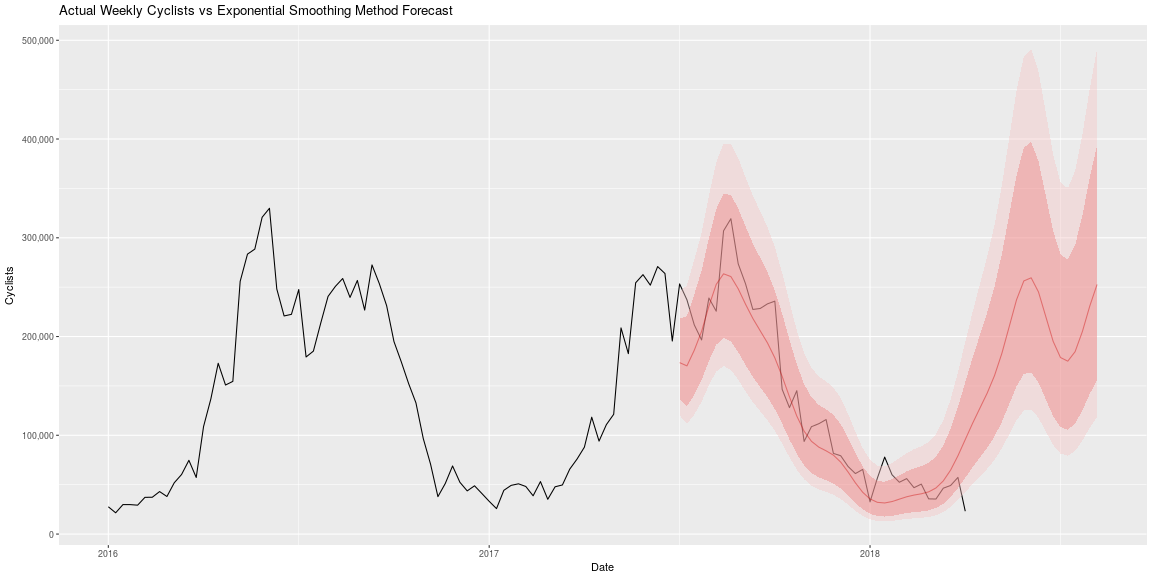

In [122]:
%%R -w 16 -h 8 -u in
autoplot(stats::window(cycle_ts[, 'Total'], start = 2016)) + 
  autolayer(cycle_ets_fcast, alpha = 0.4, col = 'red') + 
  xlab('Date') + ylab('Cyclists') + 
  scale_y_continuous(labels = scales::comma) + 
  ggtitle('Actual Weekly Cyclists vs Exponential Smoothing Method Forecast')

In [ ]:
%%R
cycle_arima <- auto.arima(train_data[, 'Total'], seasonal = TRUE, stepwise = FALSE, approximation = FALSE, stationary = FALSE, max.order = 8)
cycle_arima_fcast <- forecast::forecast(cycle_arima, h)

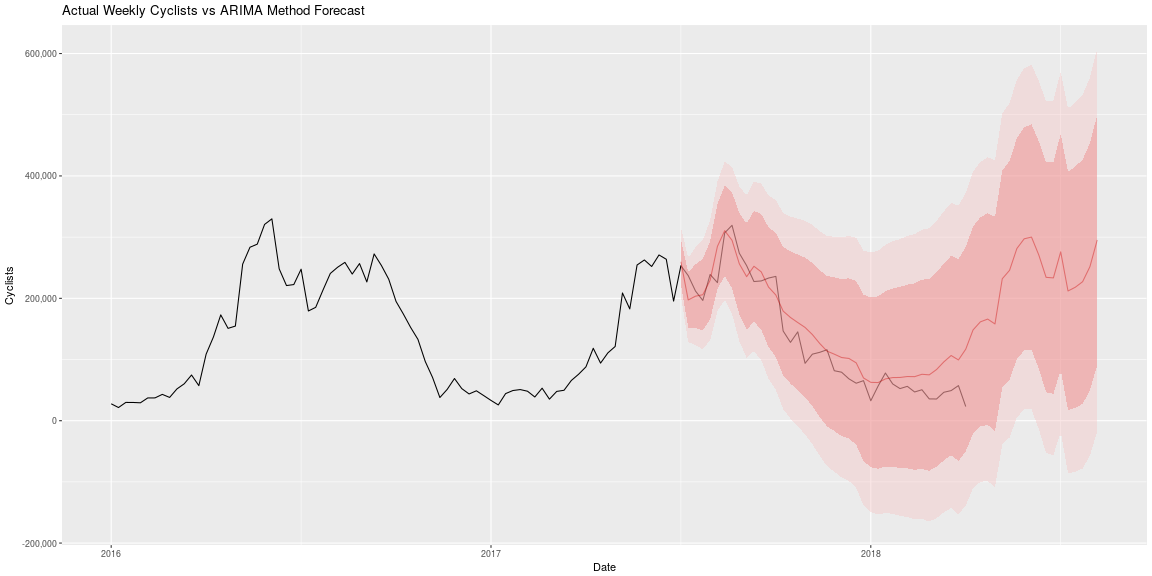

In [123]:
%%R -w 16 -h 8 -u in
autoplot(stats::window(cycle_ts[, 'Total'], start = 2016)) + 
  autolayer(cycle_arima_fcast, alpha = 0.4, col = 'red') + 
  xlab('Date') + ylab('Cyclists') + 
  scale_y_continuous(labels = scales::comma) + 
  ggtitle('Actual Weekly Cyclists vs ARIMA Method Forecast')

The methods described above used previous values of the variable of interest to predict future values but do not take into account other information. Recall that we previously identified variables that we expect to impact the number of cyclists. How can we take these into account? For this we have two options:
1. Time series regression: Linear regression is used to forecast values in a time series based on values from one or more other time series. This does not take into account subtle dynamics of the time series.
2. Dynamic regression: A combination of regression and ARIMA models where the residuals from the regression model are allowed to display autocorrelation.

In [ ]:
%%R
cycle_tslm <- forecast::tslm(Total ~ trend  + Counters + Rain_total + Temp_mean + Daylight, data = train_data)
cycle_tslm_fcast <- forecast::forecast(cycle_tslm, newdata = as.data.frame(pred_data))

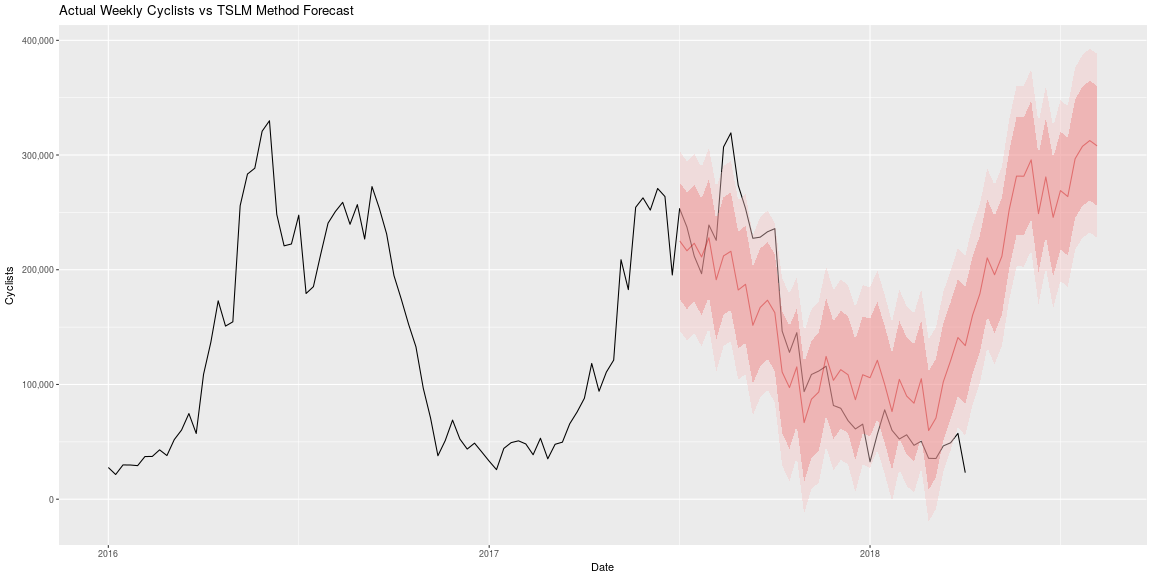

In [124]:
%%R -w 16 -h 8 -u in
autoplot(stats::window(cycle_ts[, 'Total'], start = 2016)) + 
  autolayer(cycle_tslm_fcast, alpha = 0.4, col = 'red') + 
  xlab('Date') + ylab('Cyclists') + 
  scale_y_continuous(labels = scales::comma) + 
  ggtitle('Actual Weekly Cyclists vs TSLM Method Forecast')

In [ ]:
%%R
xreg <- cbind(Counters = train_data[, 'Counters'], Rain_total = traMin_data[, 'Daylight'])
cycle_arima_xreg <- auto.arima(train_data[, 'Total'], xreg = xreg, seasonal = TRUE, stepwise = FALSE, approximation = FALSE, stationary = FALSE, max.order = 8)
cycle_arima_xreg_fcast <- forecast::forecast(cycle_arima_xreg, xreg = pred_data[, c(colnames(xreg))])

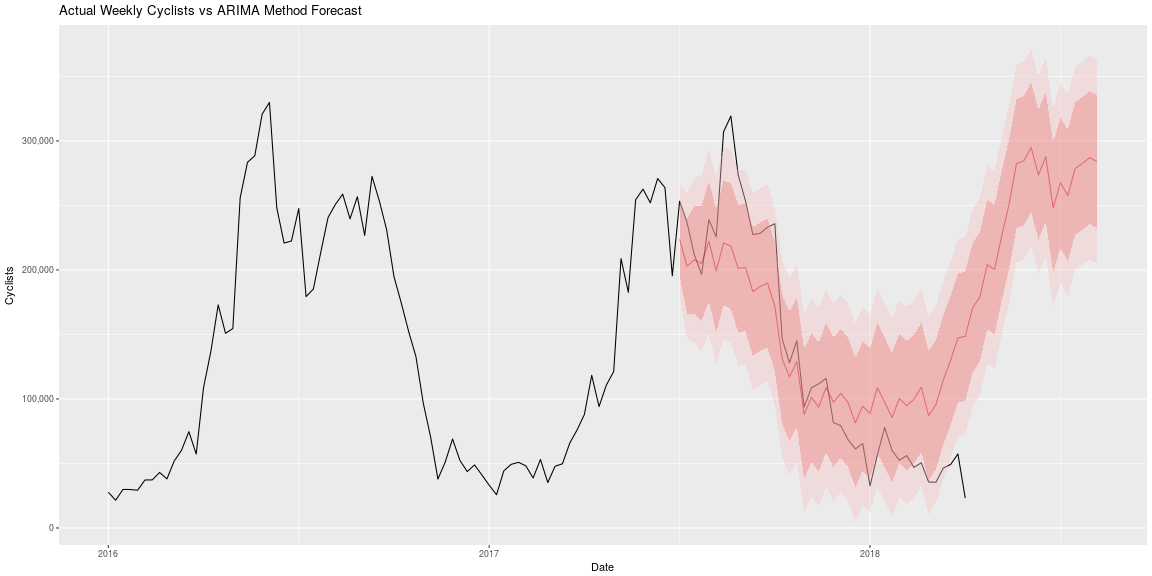

In [125]:
%%R -w 16 -h 8 -u in
autoplot(stats::window(cycle_ts[, 'Total'], start = 2016)) + 
  autolayer(cycle_aaa_fcast, alpha = 0.4, col = 'red') + 
  xlab('Date') + ylab('Cyclists') + 
  scale_y_continuous(labels = scales::comma) + 
  ggtitle('Actual Weekly Cyclists vs ARIMA Method Forecast')